<ipython-input-1-91a39713b971>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = hist['Close'][-1]  # Current price of Nifty50


Mean Absolute Error (MAE): 9050.797641525101
Root Mean Squared Error (RMSE): 9059.376000834822
   Strike  Expiration  Real_Price Option_Type     BS_Price        Error
0   15000          30         100        call  9634.167734 -9534.167734
1   15500          60         150        call  9199.525532 -9049.525532
2   16000          90         200        call  8768.699658 -8568.699658


[*********************100%%**********************]  1 of 1 completed
<ipython-input-1-91a39713b971>:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = self.data['Cumulative_Returns'][-1] - 1


Total Return: 26.82%
Annualized Return: 2.25%
Sharpe Ratio: 0.25


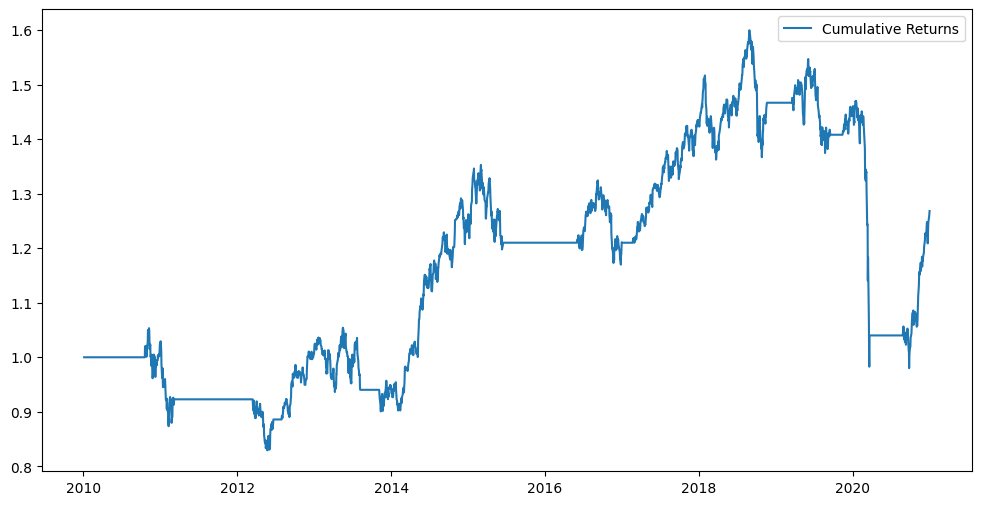

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt

# Black-Scholes Option Pricing Formula
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Fetch historical data for Nifty50 and its options
def fetch_data():
    # Fetch Nifty50 index data
    nifty50 = yf.Ticker("^NSEI")
    hist = nifty50.history(period="1y")

    # Fetch option data (this is a simplified example, real option data might require a different source)
    option_data = pd.DataFrame({
        'Strike': [15000, 15500, 16000],
        'Expiration': [30, 60, 90],  # Days to expiration
        'Real_Price': [100, 150, 200],  # Real option prices
        'Option_Type': ['call', 'call', 'call']
    })

    return hist, option_data

# Calculate Black-Scholes prices and evaluate accuracy
def evaluate_accuracy(hist, option_data):
    S = hist['Close'][-1]  # Current price of Nifty50
    r = 0.05  # Risk-free rate (assumed)
    sigma = hist['Close'].pct_change().std() * np.sqrt(252)  # Annualized volatility

    bs_prices = []
    for index, row in option_data.iterrows():
        K = row['Strike']
        T = row['Expiration'] / 365  # Convert days to years
        option_type = row['Option_Type']
        bs_price = black_scholes(S, K, T, r, sigma, option_type)
        bs_prices.append(bs_price)

    option_data['BS_Price'] = bs_prices
    option_data['Error'] = option_data['Real_Price'] - option_data['BS_Price']

    mae = np.mean(np.abs(option_data['Error']))
    rmse = np.sqrt(np.mean(option_data['Error'] ** 2))

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return option_data

class BacktestEngine:
    def __init__(self, ticker, start_date, end_date, initial_capital=10000):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.data = self.fetch_data()
        self.portfolio = {'cash': initial_capital, 'stocks': 0, 'value': initial_capital}

    def fetch_data(self):
        data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        return data

    def calculate_signals(self):
        self.data['SMA_50'] = self.data['Close'].rolling(window=50).mean()
        self.data['SMA_200'] = self.data['Close'].rolling(window=200).mean()
        self.data['Signal'] = np.where(self.data['SMA_50'] > self.data['SMA_200'], 1, -1)
        self.data['Position'] = self.data['Signal'].shift()

    def run_backtest(self):
        self.calculate_signals()
        for index, row in self.data.iterrows():
            if not np.isnan(row['Position']):
                if row['Position'] == 1 and self.portfolio['stocks'] == 0:
                    # Buy signal
                    self.portfolio['stocks'] = self.portfolio['cash'] / row['Close']
                    self.portfolio['cash'] = 0
                elif row['Position'] == -1 and self.portfolio['stocks'] > 0:
                    # Sell signal
                    self.portfolio['cash'] = self.portfolio['stocks'] * row['Close']
                    self.portfolio['stocks'] = 0
            self.portfolio['value'] = self.portfolio['cash'] + (self.portfolio['stocks'] * row['Close'])
            self.data.at[index, 'Portfolio_Value'] = self.portfolio['value']

    def evaluate_performance(self):
        self.data['Returns'] = self.data['Portfolio_Value'].pct_change()
        self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
        total_return = self.data['Cumulative_Returns'][-1] - 1
        annualized_return = (1 + total_return) ** (252 / len(self.data)) - 1
        sharpe_ratio = np.sqrt(252) * (self.data['Returns'].mean() / self.data['Returns'].std())
        print(f"Total Return: {total_return:.2%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    def plot_results(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['Cumulative_Returns'], label='Cumulative Returns')
        plt.legend()
        plt.show()

# Main function
def main():
    hist, option_data = fetch_data()
    result = evaluate_accuracy(hist, option_data)
    print(result)

    ticker = "^NSEI"
    start_date = "2010-01-01"
    end_date = "2020-12-31"
    initial_capital = 10000

    backtest = BacktestEngine(ticker, start_date, end_date, initial_capital)
    backtest.run_backtest()
    backtest.evaluate_performance()
    backtest.plot_results()

if __name__ == "__main__":
    main()